In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
%matplotlib inline

In [2]:
train = pd.read_csv(r'train.csv')    
#train.info()    
#pd.set_option('display.max_columns', 20)
train.head(10)

,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,tt0086425,"['Comedy', 'Drama']",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0085549,"['Drama', 'Romance', 'Music']",0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,tt0086465,['Comedy'],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0086567,"['Sci-Fi', 'Thriller']",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,tt0086034,"['Action', 'Adventure', 'Thriller']",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,tt0086383,"['Action', 'Thriller']",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,tt0086361,"['Drama', 'Music', 'Romance']",0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
7,tt0085970,"['Comedy', 'Drama']",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,tt0086200,"['Comedy', 'Crime', 'Drama']",0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9,tt0085995,"['Adventure', 'Comedy']",0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
category_columns = train.columns.drop(['Id', 'Genre'])

In [4]:
sum_genre = train[category_columns].sum()

In [5]:
df_movies_per_genre = pd.DataFrame({'Genre':category_columns, 'Total': sum_genre})

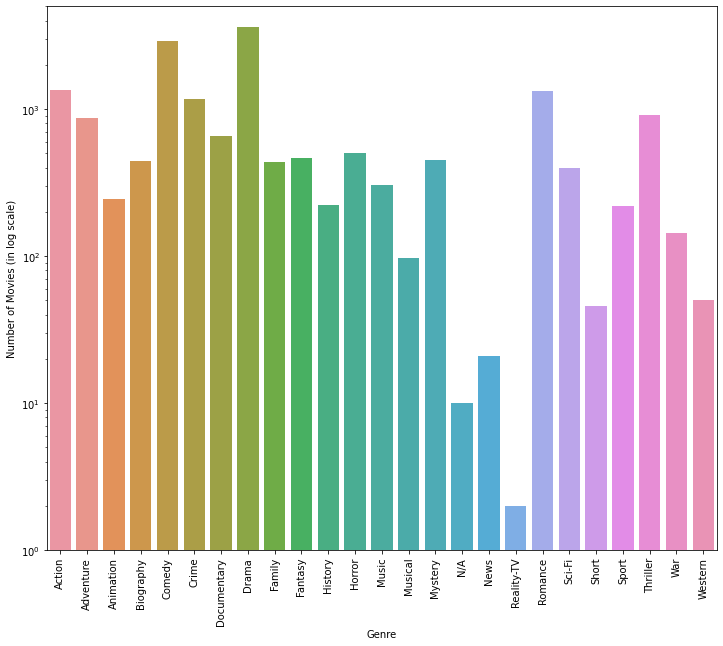

In [6]:
import seaborn as sns
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.barplot(data=df_movies_per_genre, x='Genre', y='Total', axes=ax)
ax.set(yscale='log', ylim=(1, 5000), ylabel='Number of Movies (in log scale)')
plt.xticks(rotation=90)
plt.show()

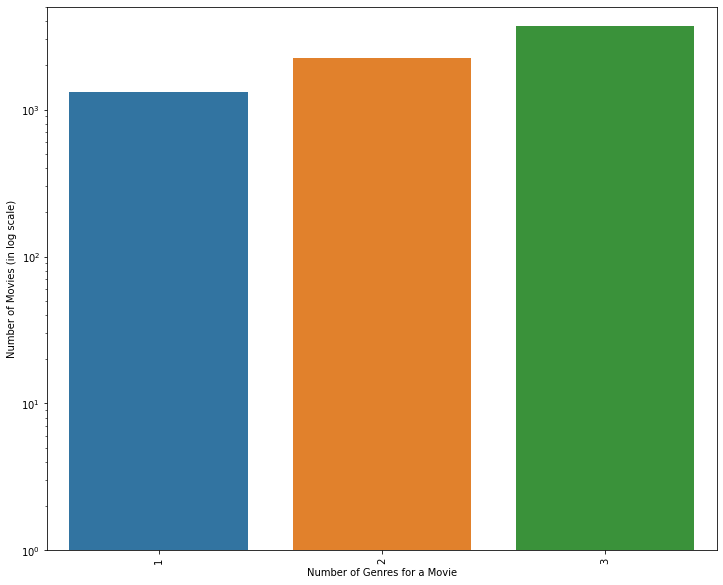

In [7]:
sum_movie = train[category_columns].sum(axis=1)
df_genres_per_movie = pd.DataFrame({'title': train.Id, 'num_genres':sum_movie}).groupby('num_genres').count()
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.barplot(data=df_genres_per_movie, x=df_genres_per_movie.index, y='title', axes=ax)
ax.set(yscale='log', ylim=(1, 5000), xlabel='Number of Genres for a Movie', ylabel='Number of Movies (in log scale)')
plt.xticks(rotation=90)
plt.show()

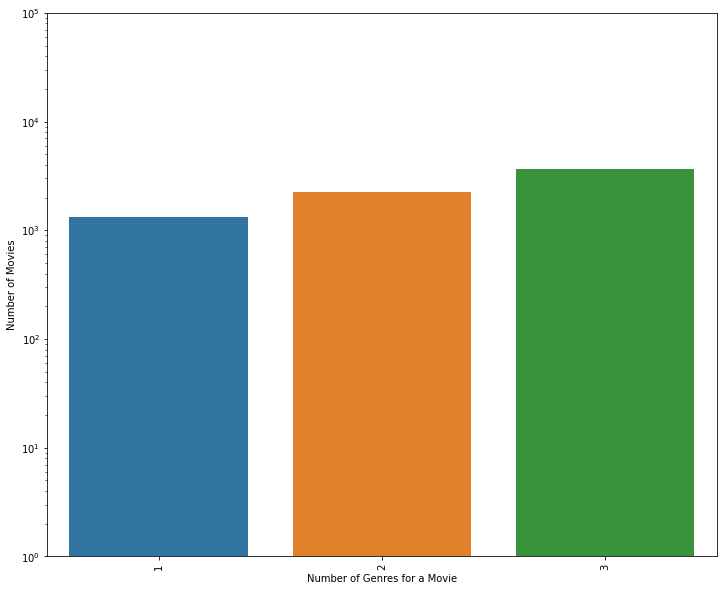

In [8]:
sum_movie = train[category_columns].sum(axis=1)
df_genres_per_movie = pd.DataFrame({'title': train.Id, 'num_genres':sum_movie}).groupby('num_genres').count()
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.barplot(data=df_genres_per_movie, x=df_genres_per_movie.index, y='title', axes=ax)
ax.set(yscale='log', ylim=(1, 1e5), xlabel='Number of Genres for a Movie', ylabel='Number of Movies')
plt.xticks(rotation=90)
plt.show()

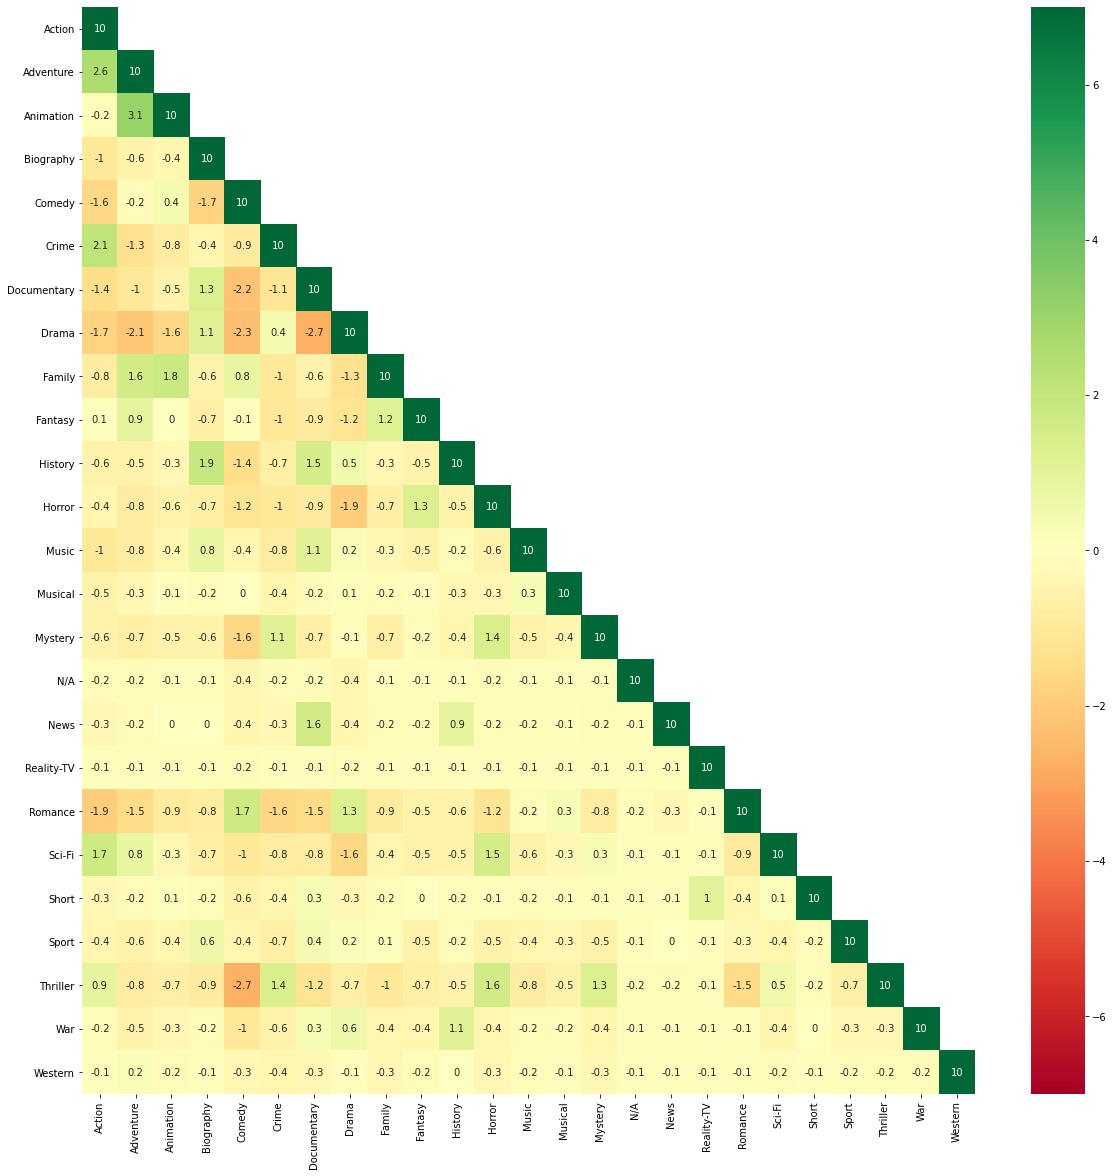

In [9]:

corr_matrix = (train[category_columns].astype('int')).corr()
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
corr_matrix = (100*corr_matrix//1)/10

fig = plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, mask=mask, annot=True, cbar=True, vmax=7, vmin=-7, cmap='RdYlGn')
plt.show()

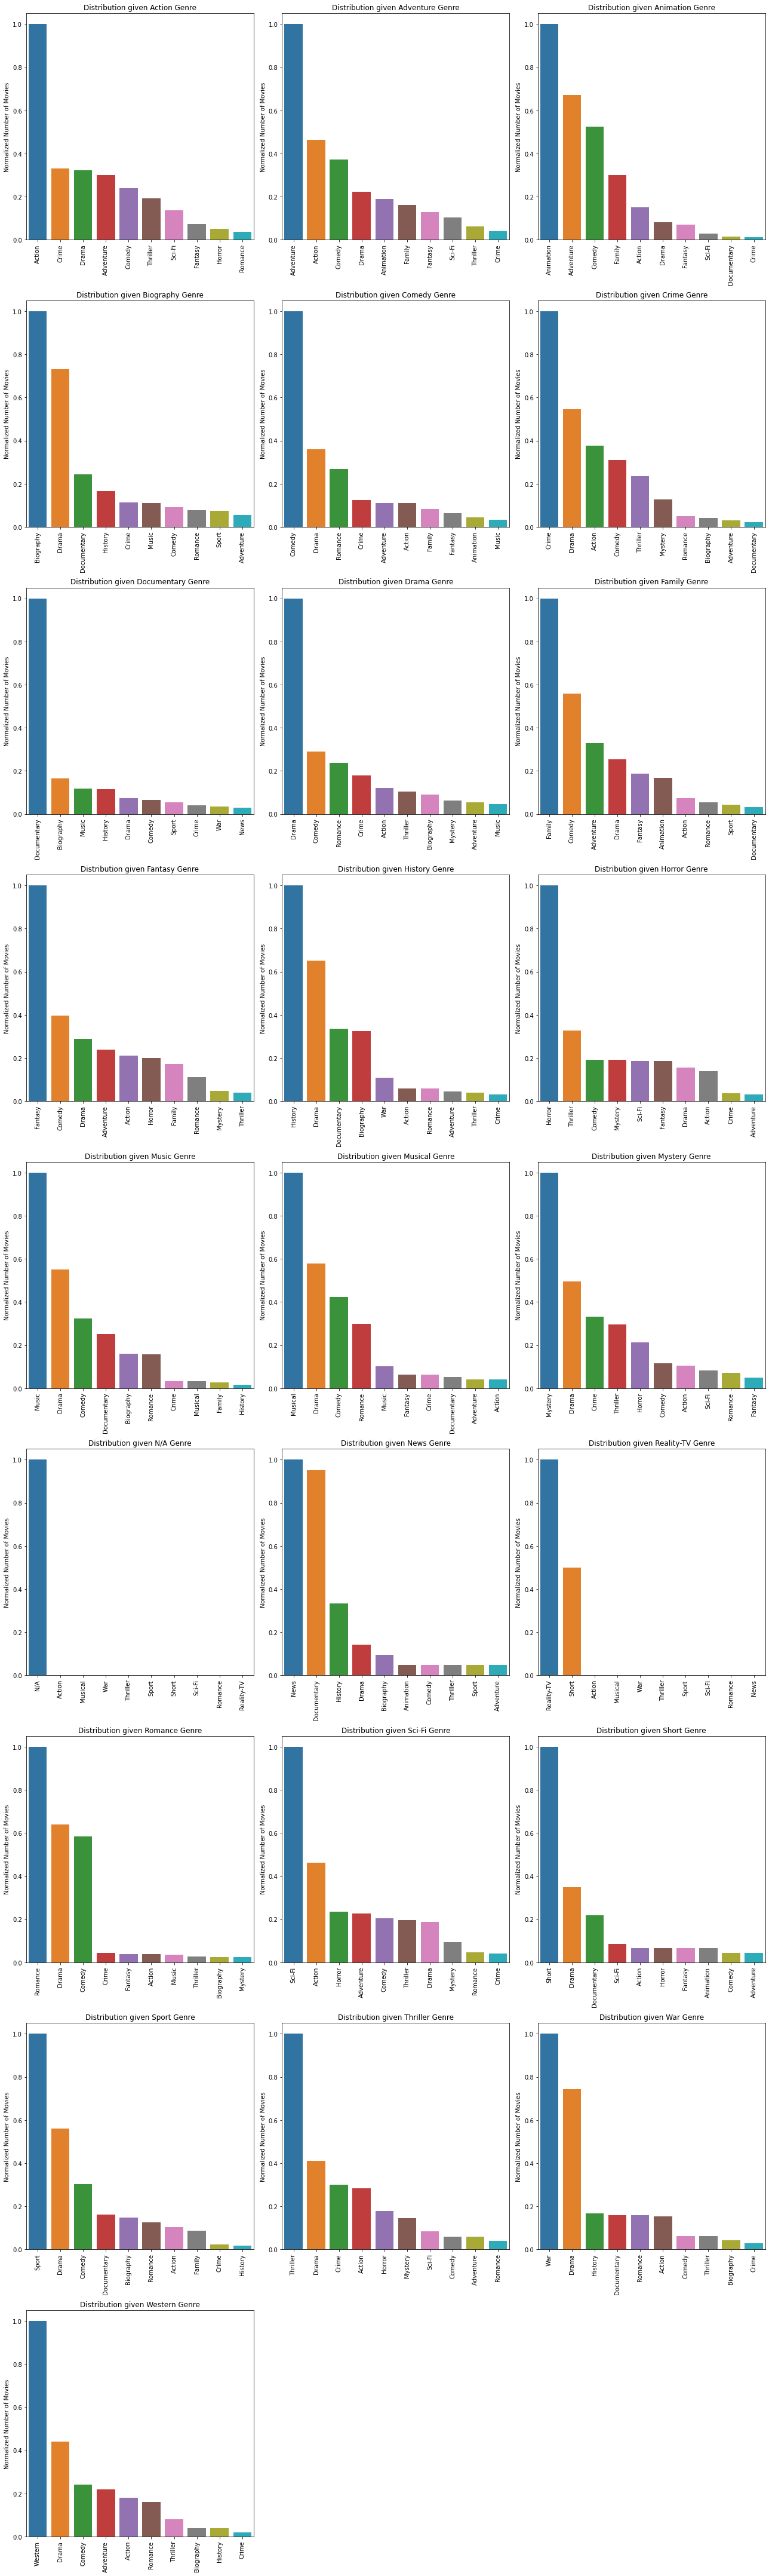

In [10]:

fig = plt.figure(figsize=(18, 60))
num_cols = 3
num_rows = math.ceil(len(category_columns)/num_cols)
for idx, col in enumerate(category_columns):
    df_sum_given_genre = pd.DataFrame({'Genre':category_columns, 'Total': train[train[col]==1][category_columns].sum()})
    df_sum_given_genre = df_sum_given_genre.sort_values('Total', ascending=False).head(10)
    df_sum_given_genre['Total'] = df_sum_given_genre['Total']/df_sum_given_genre['Total'].max()
    ax = fig.add_subplot(num_rows, num_cols, idx+1)
    sns.barplot(data=df_sum_given_genre, x='Genre', y='Total', axes=ax)
    ax.set(title='Distribution given {0} Genre'.format(col), xlabel='', ylabel='Normalized Number of Movies')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

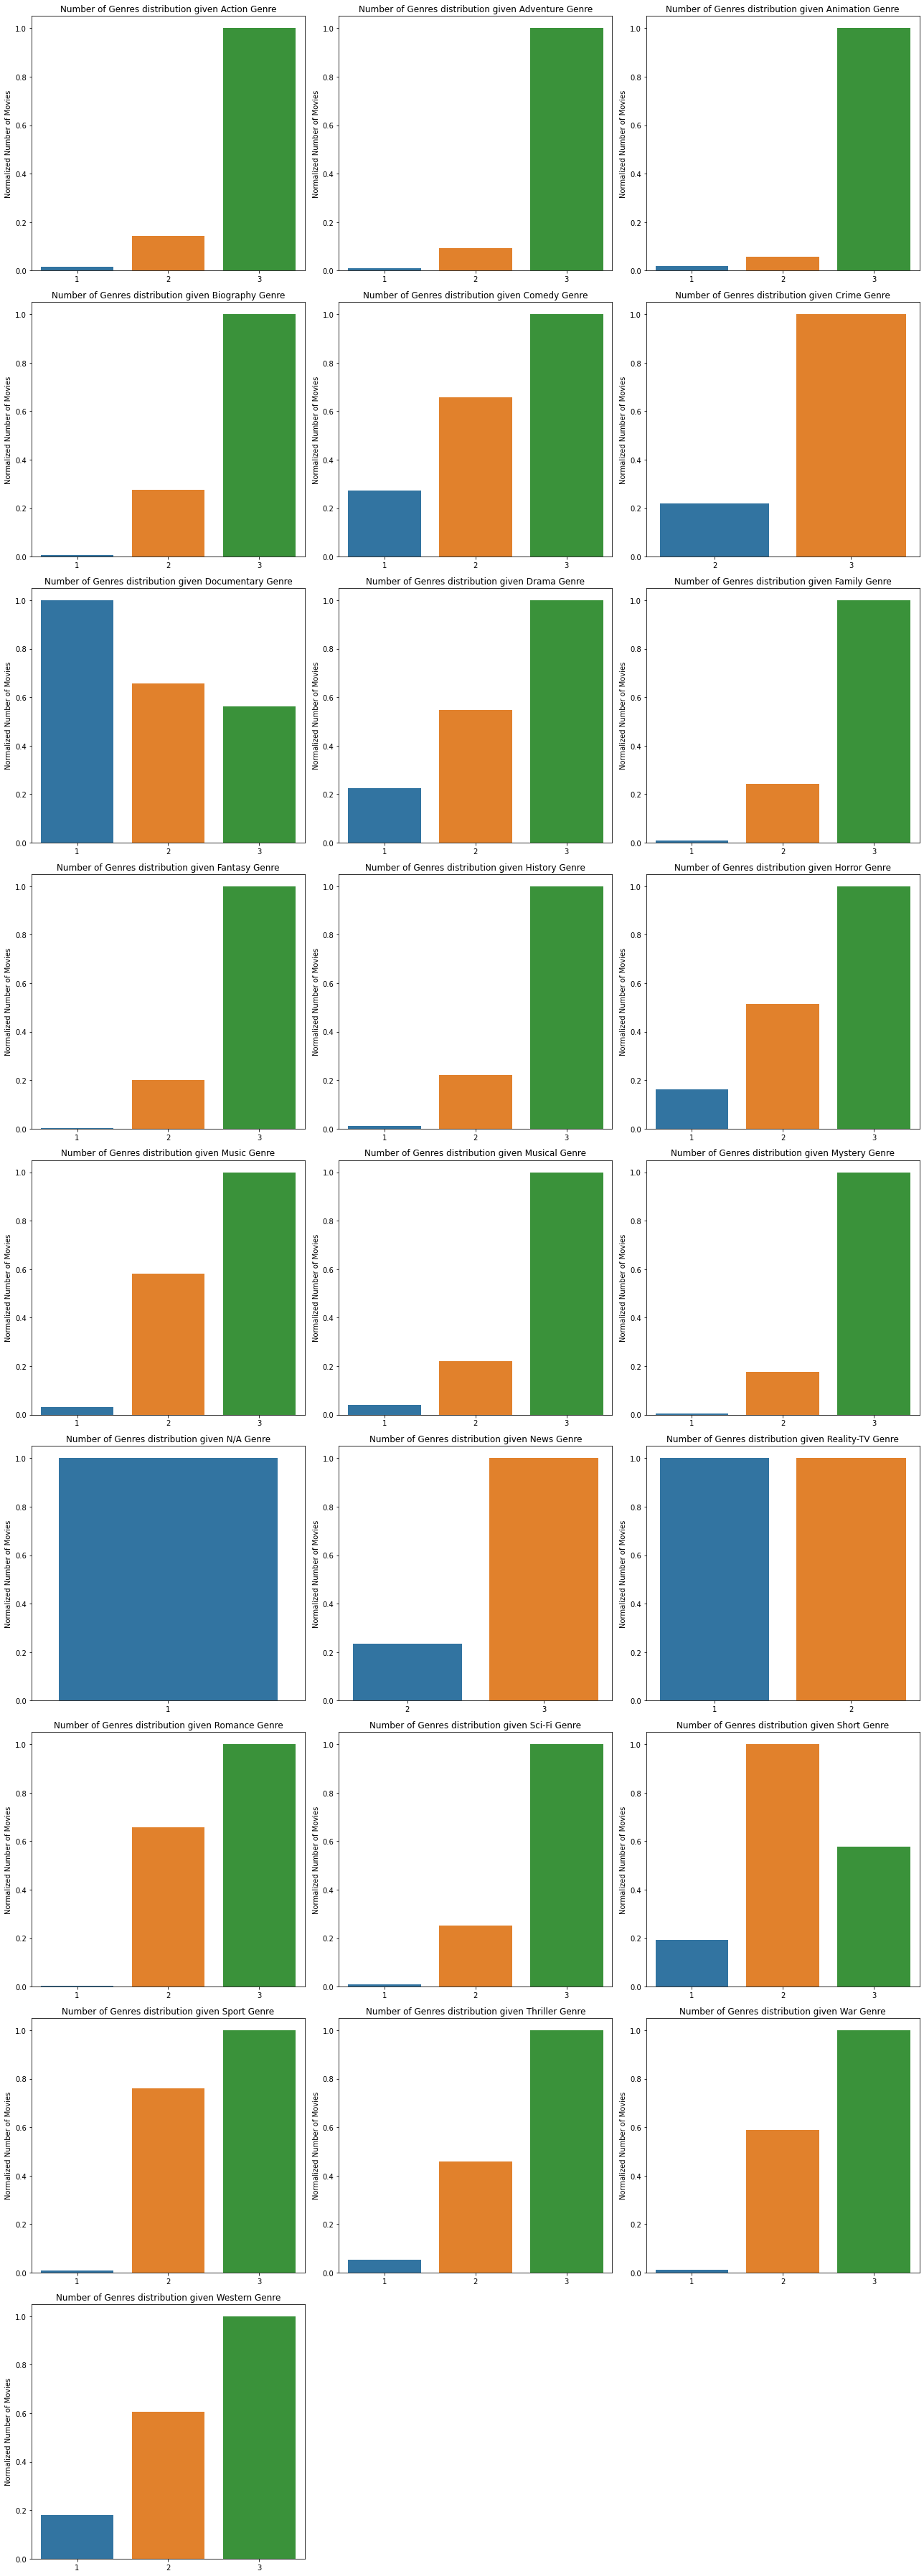

In [11]:
fig = plt.figure(figsize=(18, 50))
num_cols = 3
num_rows = math.ceil(len(category_columns)/num_cols)
for idx, col in enumerate(category_columns):
    df_genres_per_movie = pd.DataFrame({'Total': train[train[col]==1][category_columns].sum(axis=1)})
    df_numG_given_genre = pd.DataFrame(df_genres_per_movie['Total'].value_counts().sort_index().head(10))
    df_numG_given_genre['Total'] = df_numG_given_genre['Total']/df_numG_given_genre['Total'].max()
    ax = fig.add_subplot(num_rows, num_cols, idx+1)
    sns.barplot(data=df_numG_given_genre, x=df_numG_given_genre.index, y='Total', axes=ax)
    ax.set(title='Number of Genres distribution given {0} Genre'.format(col), xlabel='', ylabel='Normalized Number of Movies')

plt.tight_layout()
plt.show()